In [1]:
# --------------------
# Import general stuff
# --------------------
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import GroupKFold, GridSearchCV, KFold, GroupShuffleSplit
from sklearn.pipeline import make_pipeline

from rdkit.Chem.AllChem import MolFromSmiles, MolToInchiKey

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC, Labels
from rosvm.ranksvm.tutorial.utils import read_dataset
from rosvm.feature_extraction.featurizer_cls import EStateIndFeaturizer, CircularFPFeaturizer

RDKit WARNING: [20:41:42] Enabling RDKit 2019.09.3 jupyter extensions


# Train a RankSVM Model

## Load Training data 

Molecules are identified by there 2D InChIKey

In [2]:
_, rts, smis = read_dataset(
    "/home/bach/Documents/doctoral/python_packages/rosvm/rosvm/ranksvm/tutorial/example_data_2_mol_desc.csv")
mol = np.array([MolToInchiKey(MolFromSmiles(smi)).split("-")[0] for smi in smis])

rnd_idc = np.random.RandomState(1020).choice(np.arange(len(rts)), len(rts), replace=False)
rts, smis, mol = rts[rnd_idc], smis[rnd_idc], mol[rnd_idc]

## Train the RankSVM using GridSearchCV

In [3]:
est = make_pipeline(
    EStateIndFeaturizer(),
    KernelRankSVC(kernel="generalized_tanimoto", random_state=19, alpha_threshold=0.001)
)
pgrid = {"kernelranksvc__C": [1/4, 1/2, 1, 2, 4, 8, 16, 32]}

cv = GridSearchCV(estimator=est, param_grid=pgrid, n_jobs=4, cv=GroupKFold(n_splits=10)).fit(smis, rts, groups=mol)

<AxesSubplot:>

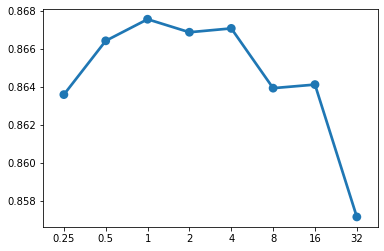

In [4]:
sns.pointplot(data=cv.cv_results_, y="mean_test_score", x="param_kernelranksvc__C")

# Predicted Preference Values

In [5]:
rsvm = cv.best_estimator_

In [76]:
con = sqlite3.connect("db/massbank__2020.11__v0.6.1.sqlite")
df = pd.read_sql("select smiles_can as smi, inchikey1 as mol, avg(retention_time) as rt from spectra_meta"
    " inner join molecules m on m.cid = spectra_meta.molecule"
    " inner join spectra_rts sr on spectra_meta.accession = sr.spectrum"
    " inner join datasets d on d.name = spectra_meta.dataset"
    " where dataset is 'LU_001' and retention_time > 3 * column_dead_time_min"
    " group by smiles_can", con)
con.close()

In [77]:
rt_pred = rsvm[1].predict_pointwise(rsvm[0].transform(df["smi"].values))
rt_true = df["rt"].values

print(rsvm[1].score_pointwise_using_predictions(rt_true, rt_pred))
print(np.sum(df["mol"].isin(mol)) / len(df) * 100)

(0.7624789450784255, 232131)
16.27565982404692


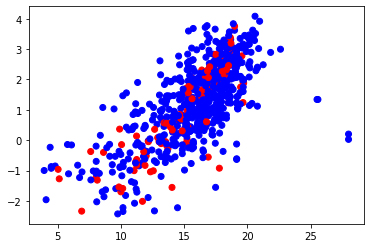

In [78]:
_col = []
_alp = []
for isin in df["mol"].isin(mol).values:
    if isin:
        _col.append("red")
    else:
        _col.append("blue")

plt.scatter(rt_true, rt_pred, color=_col)

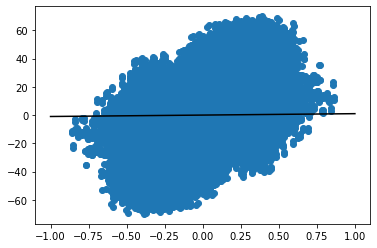

In [79]:
Y_true = (rt_true[:, np.newaxis] - rt_true[np.newaxis, :]) / np.max(rt_true)
Y_pred = (rt_pred[:, np.newaxis] - rt_pred[np.newaxis, :]) / rt_pred[np.argmax(rt_true)]
# Y_pred = (rt_pred[:, np.newaxis] - rt_pred[np.newaxis, :]) / np.max(rt_pred)

plt.scatter(Y_true.flatten(), np.abs(np.max(rt_pred) - np.min(rt_pred)) / np.abs(np.max(rt_true) - np.min(rt_true)) * Y_pred.flatten())
plt.plot([-1, 1], [-1, 1], color="black")

In [69]:
np.abs(np.max(Y_pred) - np.min(Y_pred)) 

np.abs(np.max(Y_true) - np.min(Y_true))

1.6768136950369297

In [10]:
from rlscore.learner import CGKronRLS
from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel
from rosvm.ranksvm.pair_utils import get_pairs_multiple_datasets

X = rsvm[0].transform(smis)
KX = generalized_tanimoto_kernel(X)

In [23]:
grad_times = {ds: np.max(rts[rts.get_idc_for_ds(ds)].get_rts()) for ds in rts.get_unique_dss()}

pairs_train = get_pairs_multiple_datasets(rts)[0]
_rnd_idx = np.random.RandomState(100).choice(np.arange(len(pairs_train)), 20000, replace=False)
label_row_inds = [pairs_train[idx][0] for idx in _rnd_idx]
label_col_inds = [pairs_train[idx][1] for idx in _rnd_idx]

Y = []
for i, j in zip(label_row_inds, label_col_inds):
    _rti, _dsi = rts[i]
    _rtj, _dsj = rts[j]
    assert (_dsi == _dsj)
    
    Y.append((_rti - _rtj) / grad_times[_dsi])

In [24]:
rls = CGKronRLS(K1=KX, K2=KX, regparam=1.0, Y=np.array(Y), label_row_inds=label_row_inds, label_col_inds=label_col_inds)

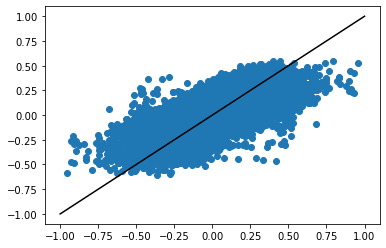

In [26]:
Y_true = -(rt_true[:, np.newaxis] - rt_true[np.newaxis, :]) / np.max(rt_true).flatten()
Y_pred = rls.predict(generalized_tanimoto_kernel(rsvm[0].transform(df["smi"].values), X),
                     generalized_tanimoto_kernel(rsvm[0].transform(df["smi"].values), X))

plt.scatter(Y_true, Y_pred)
plt.plot([-1, 1], [-1, 1], color="black")